# NCAA Basketball Game Prediction Model

This notebook uses scikit-learn to predict the outcomes of upcoming NCAA basketball games based on completed games data.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import datetime

In [2]:
# Load the data
completed_games = pd.read_csv('Completed_Games.csv')
upcoming_games = pd.read_csv('Upcoming_Games.csv')

print(f"Loaded {len(completed_games)} completed games and {len(upcoming_games)} upcoming games")

# Check if there are any upcoming games
if upcoming_games.empty:
    print("No upcoming games found. Exiting notebook.")
    import sys
    sys.exit()

Loaded 6259 completed games and 5 upcoming games


## Data Exploration

In [3]:
# Examine the data
print("Completed games columns:")
print(completed_games.columns.tolist())
completed_games.head()

Completed games columns:
['game_id', 'game_status', 'home_team', 'home_id', 'home_rank', 'home_record', 'home_score', 'away_team', 'away_id', 'away_rank', 'away_record', 'away_score', 'home_point_spread', 'home_win', 'num_ots', 'is_conference', 'is_neutral', 'is_postseason', 'tournament', 'game_day', 'game_time', 'game_loc', 'arena', 'arena_capacity', 'attendance', 'tv_network', 'referee_1', 'referee_2', 'referee_3']


,game_id,game_status,home_team,home_id,home_rank,home_record,home_score,away_team,away_id,away_rank,...,game_day,game_time,game_loc,arena,arena_capacity,attendance,tv_network,referee_1,referee_2,referee_3
0,401727499,Final,IU Indianapolis Jaguars,85,NaN,1-0,100,IU Columbus Crimson Pride,nd-iu-columbus-crimson-pride,NaN,...,"November 04, 2024",08:00 AM PST,"Indianapolis, IN",Corteva Coliseum,NaN,3716.0,ESPN+,Rod Mrakovich,Martin Spencer,Adam Sensibaugh
1,401715872,Final,Southern Illinois Salukis,79,NaN,0-1,80,Charleston Cougars,232,NaN,...,"November 04, 2024",09:00 AM PST,"Sioux Falls, SD",Sanford Pentagon,NaN,0.0,NaN,Brad Ferrie,Antinio Petty,Ben Wolfe
2,401725796,Final,UT Arlington Mavericks,250,NaN,1-0,90,UNT Dallas Trailblazers,nd-unt-dallas-trailblazers,NaN,...,"November 04, 2024",09:00 AM PST,"Arlington, TX",College Park Center,NaN,1001.0,ESPN+,Doug George,Randal Anders,Trenton Chaney
3,401726400,Final,Middle Tennessee Blue Raiders,2393,NaN,1-0,97,Oglethorpe Stormy Petrels,nd-oglethorpe-stormy-petrels,NaN,...,"November 04, 2024",09:00 AM PST,"Murfreesboro, TN",Murphy Center,NaN,7501.0,ESPN+,Kevin Mathis,James Curran,Klajdi Mulla
4,401726395,Final,Jacksonville State Gamecocks,55,NaN,1-0,112,LaGrange Panthers,nd-lagrange-panthers,NaN,...,"November 04, 2024",09:30 AM PST,"Jacksonville, AL",Pete Mathews Coliseum,NaN,2055.0,ESPN+,Barry Mathis,Nick Meyer,Jeremy Trussell


In [4]:
# Check for missing values
print("Missing values in completed games:")
print(completed_games.isna().sum()[completed_games.isna().sum() > 0])

Missing values in completed games:
home_rank            5714
home_record             7
away_rank            5866
away_record           520
home_point_spread     577
tournament           5298
arena_capacity       6259
tv_network            518
referee_1             190
referee_2             195
referee_3             220
dtype: int64


In [5]:
# Look at upcoming games structure
print("Upcoming games columns:")
print(upcoming_games.columns.tolist())
upcoming_games.head()

Upcoming games columns:
['game_id', 'game_status', 'home_team', 'home_id', 'home_rank', 'home_record', 'home_score', 'away_team', 'away_id', 'away_rank', 'away_record', 'away_score', 'home_point_spread', 'home_win', 'num_ots', 'is_conference', 'is_neutral', 'is_postseason', 'tournament', 'game_day', 'game_time', 'game_loc', 'arena', 'arena_capacity', 'attendance', 'tv_network', 'referee_1', 'referee_2', 'referee_3']


,game_id,game_status,home_team,home_id,home_rank,home_record,home_score,away_team,away_id,away_rank,...,game_day,game_time,game_loc,arena,arena_capacity,attendance,tv_network,referee_1,referee_2,referee_3
0,401726454,Scheduled,Northwestern State Demons,2466,NaN,16-16,0,John Melvin Millers,nd-john-melvin-millers,NaN,...,"November 19, 2024",04:30 PM PST,"Natchitoches, LA",Prather Coliseum,NaN,NaN,NaN,Ross Cullins,Garrett Theriot,Kevin Montz
1,401746062,Scheduled,Alabama Crimson Tide,333,2.0,27-8,0,BYU Cougars,252,6.0,...,"March 27, 2025",04:09 PM PDT,"Newark, NJ",Prudential Center,NaN,NaN,CBS,NaN,NaN,NaN
2,401746065,Scheduled,Florida Gators,57,1.0,32-4,0,Maryland Terrapins,120,4.0,...,"March 27, 2025",04:39 PM PDT,"San Francisco, CA",Chase Center,NaN,NaN,TBS/truTV,NaN,NaN,NaN
3,401746061,Scheduled,Duke Blue Devils,150,1.0,33-3,0,Arizona Wildcats,12,4.0,...,"March 27, 2025",06:39 PM PDT,"Newark, NJ",Prudential Center,NaN,NaN,CBS,NaN,NaN,NaN
4,401746063,Scheduled,Texas Tech Red Raiders,2641,3.0,27-8,0,Arkansas Razorbacks,8,10.0,...,"March 27, 2025",07:09 PM PDT,"San Francisco, CA",Chase Center,NaN,NaN,TBS/truTV,NaN,NaN,NaN


## Data Preprocessing

In [6]:
# Clean and preprocess data

# Convert records to win percentage
def extract_win_pct(record):
    if pd.isna(record) or record == '':
        return np.nan
    try:
        wins, losses = record.split('-')
        wins, losses = int(wins), int(losses)
        if wins + losses > 0:
            return wins / (wins + losses)
        return 0.5  # Default for teams with no games
    except:
        return np.nan

# Apply to both datasets
completed_games['home_win_pct'] = completed_games['home_record'].apply(extract_win_pct)
completed_games['away_win_pct'] = completed_games['away_record'].apply(extract_win_pct)

upcoming_games['home_win_pct'] = upcoming_games['home_record'].apply(extract_win_pct)
upcoming_games['away_win_pct'] = upcoming_games['away_record'].apply(extract_win_pct)

In [7]:
# Handle ranks (lower is better, NaN means unranked)
def process_rank(rank):
    if pd.isna(rank):
        return 50  # Default value for unranked teams
    try:
        return float(rank)
    except:
        return 50

completed_games['home_rank_processed'] = completed_games['home_rank'].apply(process_rank)
completed_games['away_rank_processed'] = completed_games['away_rank'].apply(process_rank)

upcoming_games['home_rank_processed'] = upcoming_games['home_rank'].apply(process_rank)
upcoming_games['away_rank_processed'] = upcoming_games['away_rank'].apply(process_rank)

In [8]:
# Create feature for point spread (betting line)
# Negative spread means home team is favored
completed_games['point_spread'] = pd.to_numeric(completed_games['home_point_spread'], errors='coerce')

# Create target variable: did home team win?
completed_games['home_team_won'] = (completed_games['home_score'] > completed_games['away_score']).astype(int)

In [9]:
# Create team statistics based on completed games

# Calculate average points scored and allowed for each team
team_stats = {}

for _, row in completed_games.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    
    # Initialize if not exists
    if home_team not in team_stats:
        team_stats[home_team] = {'games': 0, 'points_scored': 0, 'points_allowed': 0, 'wins': 0}
    if away_team not in team_stats:
        team_stats[away_team] = {'games': 0, 'points_scored': 0, 'points_allowed': 0, 'wins': 0}
    
    # Update stats
    team_stats[home_team]['games'] += 1
    team_stats[home_team]['points_scored'] += row['home_score']
    team_stats[home_team]['points_allowed'] += row['away_score']
    team_stats[home_team]['wins'] += 1 if row['home_score'] > row['away_score'] else 0
    
    team_stats[away_team]['games'] += 1
    team_stats[away_team]['points_scored'] += row['away_score']
    team_stats[away_team]['points_allowed'] += row['home_score']
    team_stats[away_team]['wins'] += 1 if row['away_score'] > row['home_score'] else 0

# Calculate averages
for team in team_stats:
    if team_stats[team]['games'] > 0:
        team_stats[team]['avg_points_scored'] = team_stats[team]['points_scored'] / team_stats[team]['games']
        team_stats[team]['avg_points_allowed'] = team_stats[team]['points_allowed'] / team_stats[team]['games']
        team_stats[team]['win_pct'] = team_stats[team]['wins'] / team_stats[team]['games']
    else:
        team_stats[team]['avg_points_scored'] = 70  # Default values
        team_stats[team]['avg_points_allowed'] = 70
        team_stats[team]['win_pct'] = 0.5

In [10]:
# Function to add team stats to games dataframe
def add_team_stats(df):
    # Initialize new columns
    df['home_avg_points'] = np.nan
    df['home_avg_points_allowed'] = np.nan
    df['home_calculated_win_pct'] = np.nan
    df['away_avg_points'] = np.nan
    df['away_avg_points_allowed'] = np.nan
    df['away_calculated_win_pct'] = np.nan
    
    # Populate with stats
    for i, row in df.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        
        if home_team in team_stats:
            df.at[i, 'home_avg_points'] = team_stats[home_team]['avg_points_scored']
            df.at[i, 'home_avg_points_allowed'] = team_stats[home_team]['avg_points_allowed']
            df.at[i, 'home_calculated_win_pct'] = team_stats[home_team]['win_pct']
        
        if away_team in team_stats:
            df.at[i, 'away_avg_points'] = team_stats[away_team]['avg_points_scored']
            df.at[i, 'away_avg_points_allowed'] = team_stats[away_team]['avg_points_allowed']
            df.at[i, 'away_calculated_win_pct'] = team_stats[away_team]['win_pct']
    
    return df

# Add stats to both datasets
completed_games = add_team_stats(completed_games)
upcoming_games = add_team_stats(upcoming_games)

In [11]:
# Create additional features for modeling
def create_model_features(df):
    # Create matchup features
    df['rank_difference'] = df['away_rank_processed'] - df['home_rank_processed']
    df['win_pct_difference'] = df['home_calculated_win_pct'] - df['away_calculated_win_pct']
    df['scoring_diff'] = df['home_avg_points'] - df['away_avg_points']
    df['defense_diff'] = df['away_avg_points_allowed'] - df['home_avg_points_allowed']
    df['points_diff'] = df['home_avg_points'] - df['away_avg_points']
    df['allowed_points_diff'] = df['home_avg_points_allowed'] - df['away_avg_points_allowed']
    
    # Home court advantage (is_neutral=False means home advantage exists)
    df['home_advantage'] = (~df['is_neutral'].astype(bool)).astype(int)
    
    return df

completed_games = create_model_features(completed_games)
upcoming_games = create_model_features(upcoming_games)

## Model Building

In [12]:
# Select features for modeling
features = [
    'home_rank_processed', 'away_rank_processed', 'rank_difference',
    'home_calculated_win_pct', 'away_calculated_win_pct', 'win_pct_difference',
    'home_avg_points', 'away_avg_points', 'scoring_diff',
    'home_avg_points_allowed', 'away_avg_points_allowed', 'defense_diff',
    'home_advantage', 'points_diff', 'allowed_points_diff'
]

# Filter rows with complete data for features
model_data = completed_games.dropna(subset=features)
print(f"Using {len(model_data)} out of {len(completed_games)} games for modeling")

X = model_data[features]
y = model_data['home_team_won']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Using 6259 out of 6259 games for modeling


In [13]:
# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create full preprocessing and modeling pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', numeric_transformer),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False],
    'classifier__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Evaluate on test data
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy on test data: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Cross-validation score
cv_scores = cross_val_score(best_model, X, y, cv=5)
print(f"\nCross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Best parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Model accuracy on test data: 0.7565

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.51      0.58       515
           1       0.79      0.88      0.83      1050

    accuracy                           0.76      1565
   macro avg       0.73      0.69      0.70      1565
weighted avg       0.75      0.76      0.75      1565




Cross-validation accuracy: 0.7557 ± 0.0105


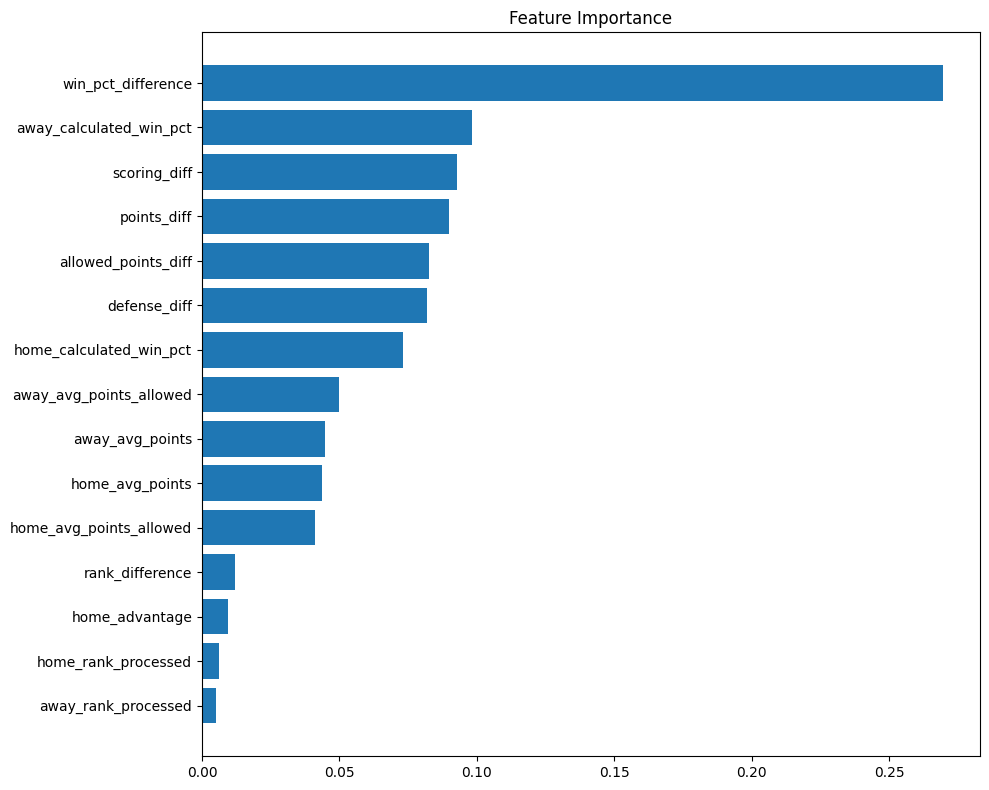

In [14]:
# Feature importance
feature_importance = best_model.named_steps['classifier'].feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## Predicting Upcoming Games

In [15]:
# Prepare upcoming games data for prediction
existing_features = [feature for feature in features if feature in upcoming_games.columns]

# Drop rows with missing values in other features
upcoming_features = upcoming_games.dropna(subset=existing_features)

# Check if there are any rows left for prediction
if upcoming_features.empty:
    print("No upcoming games with sufficient data for prediction. Exiting prediction step.")
else:
    print(f"Making predictions for {len(upcoming_features)} out of {len(upcoming_games)} upcoming games")

    # Fill missing values in other features with 0
    for feature in existing_features:
        if feature not in upcoming_features.columns:
            upcoming_features[feature] = 0
        else:
            upcoming_features.loc[:, feature] = upcoming_features[feature].fillna(0)

    # Make predictions
    X_upcoming = upcoming_features[existing_features]
    upcoming_features['home_win_probability'] = best_model.predict_proba(X_upcoming)[:, 1]
    upcoming_features['predicted_winner'] = np.where(
        upcoming_features['home_win_probability'] > 0.5,
        upcoming_features['home_team'],
        upcoming_features['away_team']
    )
    upcoming_features['win_probability'] = np.where(
        upcoming_features['home_win_probability'] > 0.5,
        upcoming_features['home_win_probability'],
        1 - upcoming_features['home_win_probability']
    )

Making predictions for 4 out of 5 upcoming games


/tmp/ipykernel_2312/2802390730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upcoming_features['home_win_probability'] = best_model.predict_proba(X_upcoming)[:, 1]
/tmp/ipykernel_2312/2802390730.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upcoming_features['predicted_winner'] = np.where(
/tmp/ipykernel_2312/2802390730.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [16]:
# Sort and display predictions
required_columns = ['game_day', 'home_team', 'away_team', 'predicted_winner', 'win_probability']
if all(column in upcoming_features.columns for column in required_columns):
    prediction_results = upcoming_features[required_columns].sort_values('game_day')
    prediction_results.head(10)
else:
    print("Required columns for predictions are missing. Ensure the prediction step was successful.")

## Model Analysis and Insights

In [17]:
import datetime

# Export predictions to CSV
if 'prediction_results' in locals() and not prediction_results.empty:
    prediction_results.to_csv('NCAA_Game_Predictions.csv', index=False)
    print("Predictions exported to NCAA_Game_Predictions.csv")
else:
    print("No predictions available to export. Ensure the prediction step was successful.")

# Ensure high_confidence is defined
if 'prediction_results' in locals() and not prediction_results.empty:
    high_confidence = prediction_results[prediction_results['win_probability'] > 0.8].sort_values('win_probability', ascending=False)
else:
    high_confidence = pd.DataFrame()  # Define as an empty DataFrame if predictions are unavailable

# Prepare new README content
readme_content = [
    '# NCAA Game Predictions\n\n',
    'This project aims to predict the outcomes of NCAA basketball games using machine learning models. The code leverages the `scikit-learn` library for building and evaluating the models, and the `cbbpy` library for scraping game data.\n\n',
    '## High Confidence Predictions:\n'
]

if not high_confidence.empty:
    # Format high confidence predictions with readable headers
    high_confidence = high_confidence.rename(columns={
        'game_day': 'Game Day',
        'home_team': 'Home Team',
        'away_team': 'Away Team',
        'predicted_winner': 'Predicted Winner',
        'win_probability': 'Win Probability'
    })

    # Round Win Probability to 2 decimal places
    high_confidence['Win Probability'] = high_confidence['Win Probability'].round(2)

    # Convert high confidence predictions to a Markdown table
    high_confidence_table = high_confidence.head(10).to_markdown(index=False)

    # Add high confidence predictions to README content
    readme_content.append(high_confidence_table)
else:
    # Add a note if no highly confident predictions were made
    readme_content.append("No highly confident predictions were made for the upcoming games.\n\n")

# Add the new description and libraries used content at the bottom
description_content = [
    '## Description\n\n',
    'The main functionalities of this project include:\n\n',
    '- Scraping NCAA basketball game data using the `cbbpy` library.\n',
    '- Preprocessing the data for model training.\n',
    '- Building and evaluating machine learning models using `scikit-learn`.\n',
    '- Generating predictions for upcoming games.\n',
    '- Exporting predictions to [NCAA_Game_Predictions.csv](NCAA_Game_Predictions.csv).\n',
    '- Updating the README file with the latest model performance and high confidence predictions.\n\n',
    '## Libraries Used\n\n',
    '- [scikit-learn](https://scikit-learn.org/stable/): A machine learning library for Python that provides simple and efficient tools for data mining and data analysis.\n',
    '- [cbbpy](https://pypi.org/project/cbbpy/): A Python library for scraping NCAA basketball data.\n\n'
]

# Add the last updated date and time
last_updated = datetime.datetime.now().strftime("%B %d, %Y at %I:%M %p")
last_updated_content = [f'**Last updated:** {last_updated}\n']

# Combine all content
readme_content += description_content + last_updated_content

# Write the new README content to the file
with open('README.md', 'w') as file:
    file.writelines(readme_content)
print("README.md updated with latest model performance and high confidence predictions.\n\n")

Predictions exported to NCAA_Game_Predictions.csv
README.md updated with latest model performance and high confidence predictions.




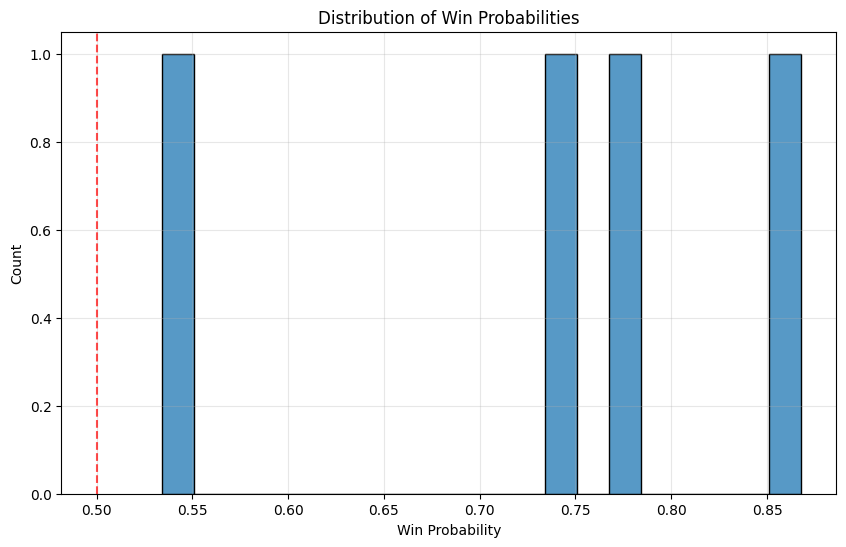

In [18]:
# Create visualization of prediction distribution
if 'win_probability' in upcoming_features.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(upcoming_features['win_probability'], bins=20)
    plt.title('Distribution of Win Probabilities')
    plt.xlabel('Win Probability')
    plt.ylabel('Count')
    plt.axvline(0.5, color='red', linestyle='--', alpha=0.7)
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("The 'win_probability' column is missing. Ensure the prediction step was successful.")